# NARPS: design optimalisation

In this notebook, we're developing an optimal experimental design for a mixed gambled task.

A few shortcomings:
- I haven't taken into account temporal autocorrelation or the possibility of drift (will try to add this the following days)

In [198]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
import scipy


%matplotlib inline

## Define hrf functions

In [199]:
def spm_Gpdf(s,h,l):
    s = np.array(s)
    res = (h-1)*np.log(s) + h*np.log(l) - l*s - np.log(gamma(h))
    return np.exp(res)

def canonical(resolution):
    # translated from spm_hrf
    p=[6,16,1,1,6,0,32]
    dt = resolution/16.
    s = np.array(xrange(int(p[6]/dt+1)))
    #HRF sampled at 0.1 s
    hrf = spm_Gpdf(s,p[0]/p[2],dt/p[2]) - spm_Gpdf(s,p[1]/p[3],dt/p[3])/p[4]
    hrf = hrf[[int(x) for x in np.array(xrange(int(p[6]/resolution+1)))*16.]]
    hrf = hrf/np.sum(hrf)
    # duration of the HRF
    durhrf = 32.0
    # length of the HRF parameters in resolution scale
    laghrf = int(np.ceil(durhrf/resolution))
    hrf = hrf[:laghrf]

    return {"basishrf":hrf,"laghrf":laghrf}

## Define class for the experiment

There are a few settings that can be changed in the functions:
- The total number of trials: 256
- The ITI: 6 seconds --> **note: we assume a fixed ITI, could (and maybe should) be jittered !**
- The resolution: 0.1 seconds
- The gains: range 10\$ - 40\$, by 2\$ (as Tom et al.)
- The losses: range 5\$ - 20\$, by 1\$ (as Tom et al.)

In [200]:
class experiment(object):
    def __init__(self,ntrials=256,ITI=6,resolution=0.1):
        self.ntrials = ntrials
        self.ITI = ITI
        self.resolution = resolution
        self.xaxis = np.arange(0,ntrials*ITI,resolution)
    
    def get_experiment(self):
        self.onsets = range(0,len(totallen),int(self.ITI/self.resolution))
        self.gains = np.round(np.random.uniform(10,40,self.ntrials)/2)*2
        self.losses = np.round(np.random.uniform(4,20,self.ntrials))
        distance = gains-losses
        
        reg_task = np.zeros(int(self.ntrials*self.ITI/self.resolution))
        reg_task[onsets] = 1
        reg_task_c = np.convolve(reg_task,canonical(self.resolution)['basishrf'][:len(reg_task)])
        
        reg_gain = np.zeros(int(self.ntrials*self.ITI/self.resolution))
        reg_gain[onsets] = (self.gains-np.mean(self.gains))/np.std(self.gains)
        reg_gain_c = np.convolve(reg_gain,canonical(self.resolution)['basishrf'][:len(reg_gain)])
        
        reg_loss = np.zeros(int(self.ntrials*self.ITI/self.resolution))
        reg_loss[onsets] = (self.losses-np.mean(self.losses))/np.std(self.losses)
        reg_loss_c = np.convolve(reg_loss,canonical(self.resolution)['basishrf'][:len(reg_loss)])

        reg_dist = np.zeros(int(self.ntrials*self.ITI/self.resolution))
        reg_dist[onsets] = (distance-np.mean(distance))/np.std(distance)
        reg_dist_c = np.convolve(reg_dist,canonical(self.resolution)['basishrf'][:len(reg_dist)])
      
        self.design = np.array([reg_task,reg_gain,reg_loss,reg_dist])
        self.design_c = np.array([reg_task_c,reg_gain_c,reg_loss_c,reg_dist_c])
               
        return self

    def compute_efficiency(self,contrasts):
        
        C = contrasts
        
        XtX = np.dot(EXP.design_c,EXP.design_c.T)  
        invZ = scipy.linalg.inv(XtX)
        CMC = np.matrix(C)*np.matrix(invZ)*np.matrix(C.T)
        
        self.Aopt = float(len(C) / np.matrix.trace(CMC))
        
        return self


## Example of creating a random design

In [201]:
EXP = experiment()
EXP.get_experiment()

# print out gains and losses choice
print("Gains: %s"%(str(EXP.gains)))
print("Losses: %s"%(str(EXP.losses)))


Gains: [ 18.  16.  30.  22.  30.  18.  24.  40.  18.  10.  30.  40.  32.  32.  38.
  16.  40.  14.  24.  28.  38.  16.  24.  20.  24.  32.  32.  24.  18.  16.
  32.  16.  22.  32.  16.  22.  22.  20.  18.  36.  32.  12.  18.  34.  38.
  24.  40.  24.  34.  32.  34.  12.  34.  22.  10.  18.  36.  16.  26.  34.
  36.  34.  36.  40.  18.  30.  38.  24.  10.  36.  40.  12.  28.  26.  16.
  20.  10.  26.  26.  22.  34.  26.  28.  30.  36.  26.  12.  18.  36.  32.
  28.  38.  10.  26.  16.  32.  32.  18.  24.  34.  34.  12.  28.  32.  34.
  12.  12.  12.  14.  12.  28.  32.  12.  28.  22.  16.  12.  38.  30.  34.
  28.  38.  28.  16.  26.  18.  30.  36.  18.  18.  16.  40.  28.  14.  20.
  30.  10.  20.  16.  18.  38.  34.  24.  36.  24.  12.  22.  14.  22.  34.
  20.  30.  24.  22.  20.  22.  26.  24.  10.  38.  28.  20.  10.  32.  18.
  18.  14.  32.  20.  22.  26.  36.  28.  30.  14.  12.  20.  26.  38.  14.
  18.  26.  26.  40.  12.  40.  26.  14.  22.  16.  26.  32.  22.  28.  40.
  30.

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


#### This figure below shows the expected BOLD signal with the task.  If there would be a complete separability between gains and losses and the difference between both, the following plot shows the expected BOLD signal

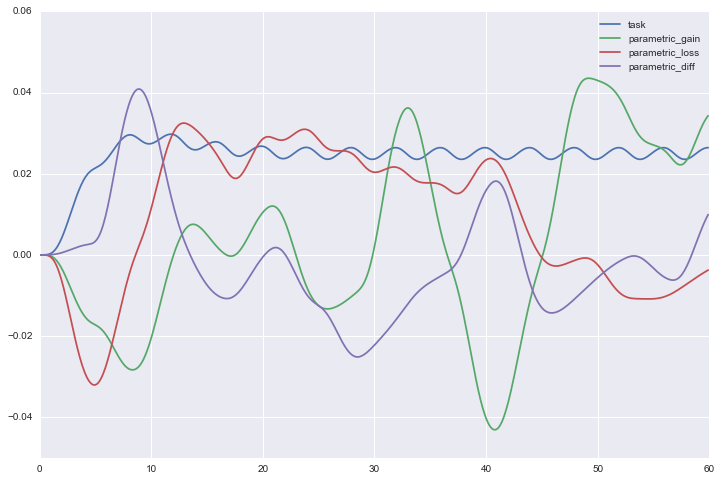

In [202]:
# generate figure
plt.figure(figsize=(12,8))
labs = ["task",'parametric_gain','parametric_loss','parametric_diff']
for x in range(4):
    plt.plot(EXP.xaxis[:600],EXP.design_c.T[:600,x],label=labs[x])
plt.ylim([-0.05,0.06])
plt.legend()

### Contrasts
To compute the efficiency of the design, we also need to define the contrasts.  Here I defined a contrast of 
- main effect of task
- difference between loss and gain trials

Of course you can/should change as you please :-)

In [203]:
cons = np.array([
        [1,0,0,0],
        [0,1,-1,0]
    ])

EXP.compute_efficiency(cons)
print(EXP.Aopt)

3.30743136027


## Generate random designs and optimise

In [204]:
allexp = []
for seed in range(100):
    EXP = experiment()
    EXP.get_experiment()
    cons = np.array([
            [1,0,0,0],
            [0,1,-1,0]
        ])
    EXP.compute_efficiency(cons)
    #print("Random experiment %i: efficiency %d"%(seed,EXP.Aopt))
    out = {"opt":EXP.Aopt,"gains":EXP.gains,"losses":EXP.losses,"experiment":EXP.design_c,"xaxis":EXP.xaxis}
    allexp.append(out)
    EXP = None


/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


## Extract optimal design

Distribution of optimisation scores:

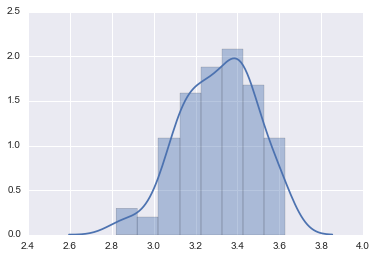

In [185]:
opt = [x['opt'] for x in allexp]
sns.distplot(opt)

Optimal design:

In [186]:
optind = int(np.where(np.array(opt)==np.max(opt))[0])
optimum = allexp[optind]
print(optimum)

{'opt': 3.62800406024914, 'losses': array([ 10.,   7.,   5.,  12.,  15.,   5.,   9.,   5.,   4.,  10.,   9.,
         5.,  14.,  17.,   5.,  17.,   6.,   7.,  18.,  12.,  18.,  15.,
        18.,   8.,  12.,  12.,  20.,  16.,  15.,  18.,   9.,   7.,   9.,
         5.,  16.,   6.,   4.,  14.,  10.,  19.,  15.,   8.,   9.,  17.,
        13.,   5.,   9.,  19.,   6.,  16.,  19.,  15.,  19.,   8.,  10.,
         9.,   7.,  11.,   7.,  17.,   5.,  16.,  13.,  19.,  20.,  19.,
        16.,   9.,  15.,   7.,  16.,   8.,  10.,  15.,   5.,   9.,  16.,
        14.,   6.,  20.,  19.,  19.,  18.,   8.,  13.,  17.,  16.,   4.,
        14.,  17.,  19.,  20.,  15.,   5.,   9.,  16.,   5.,  11.,  19.,
        19.,  18.,   6.,  18.,   5.,  15.,  12.,  13.,   5.,  19.,  15.,
        11.,  17.,  18.,  18.,  10.,  17.,  17.,   7.,  12.,   4.,   9.,
        16.,  15.,  18.,   5.,   5.,  20.,   8.,  10.,  19.,   7.,  11.,
         8.,  18.,  11.,  12.,  16.,  17.,  12.,   9.,  16.,  14.,  16.,
         8.,   

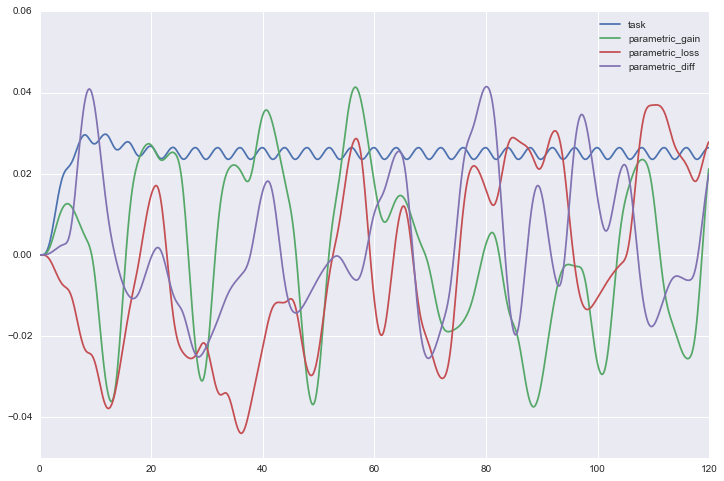

In [196]:
# generate figure
plt.figure(figsize=(12,8))
labs = ["task",'parametric_gain','parametric_loss','parametric_diff']
for x in range(4):
    plt.plot(optimum['xaxis'][:1200],optimum['experiment'].T[:1200,x],label=labs[x])

plt.ylim([-0.05,0.06])
plt.legend()